# Exploratory Data Analysis

## Setup and Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import string
import re
from itertools import combinations
from collections import Counter, defaultdict
from typing import Dict, List
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from tqdm import tqdm
import spacy
from sklearn.feature_extraction.text import CountVectorizer

from vtt.data.caption_preprocessing import (
    load_and_clean_captions, 
    build_raw_captions_dict_from_csv
)
from vtt.evaluation.metrics import (
    compute_bleu_scores,
    compute_meteor_scores,
    compute_bertscore,
)

2025-07-18 14:11:50.877707: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-18 14:11:50.891645: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752862310.905309    5929 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752862310.909055    5929 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752862310.920436    5929 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Define Output Directory

In [ ]:
output_dir = "../outputs/figures/eda"

## Image EDA

### Image Directory Path

In [3]:
image_folder = "../../data/flickr8k_images/"

### Dimension Analysis

In [3]:
widths, heights = [], []
for filename in tqdm(os.listdir(image_folder), desc="Processing images dimensions"):
    if filename.endswith((".jpg", ".jpeg", ".png")):
        with Image.open(os.path.join(image_folder, filename)) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)

Processing images dimensions: 100%|████████████████████████████████████████████████| 8092/8092 [00:26<00:00, 302.65it/s]


#### Distribution of Heights and Widths

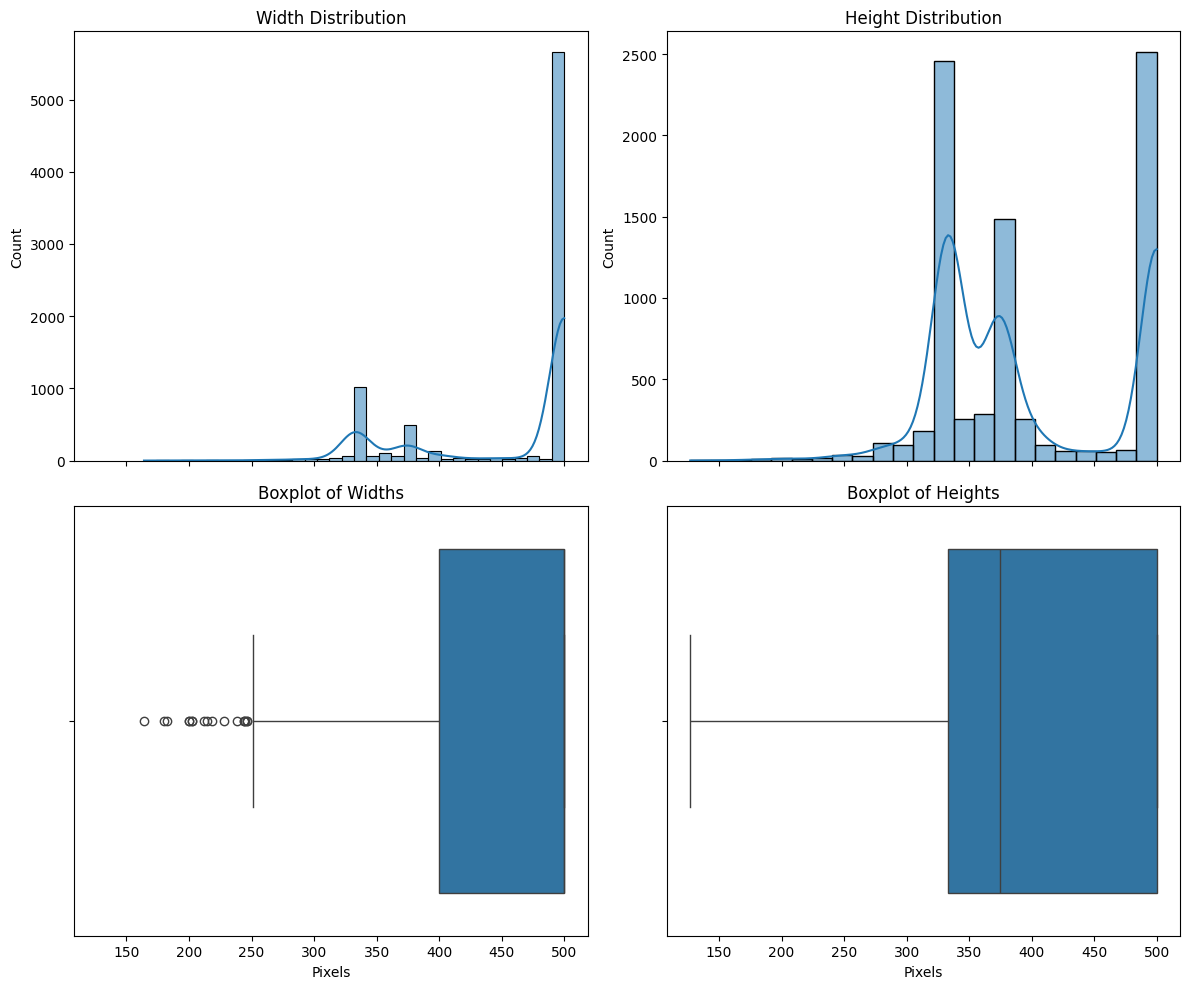

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True)

sns.histplot(widths, kde=True, ax=axs[0, 0])
axs[0, 0].set_title("Width Distribution")

sns.histplot(heights, kde=True, ax=axs[0, 1])
axs[0, 1].set_title("Height Distribution")

sns.boxplot(x=widths, ax=axs[1, 0])
axs[1, 0].set_title("Boxplot of Widths")
axs[1, 0].set_xlabel("Pixels")

sns.boxplot(x=heights, ax=axs[1, 1])
axs[1, 1].set_title("Boxplot of Heights")
axs[1, 1].set_xlabel("Pixels")

fig.savefig(os.path.join(output_dir, "eda_image_dimension_distributions.png")
plt.tight_layout()
plt.show()

#### Summary Stats

In [5]:
print("Width Stats:\n\t",
      f"Min: {np.min(widths)}, Max: {np.max(widths)}, Mean: {np.mean(widths)}")
print("Height Stats:\n\t",
      f"Min: {np.min(heights)}, Max: {np.max(heights)}, Mean: {np.mean(heights)}")

Width Stats:
	 Min: 164, Max: 500, Mean: 457.87220368310466
Height Stats:
	 Min: 127, Max: 500, Mean: 397.25188481028306


#### Interpretation

Widths: 
* There's a very large spike around 500 pixels, suggesting many images are resized or naturally close to that width.
* Interquartile range (IQR) is fairly narrow.
* There are outliers on the lower end (~<300 px), possibly small thumbnails or improperly sized images.

Heights: 
* Multiple peaks — around 375 px and 500 px — indicating at least two dominant height clusters. This suggests inconsistent image sizing.
* Similar to widths, there are outliers on the lower end, though the height distribution seems slightly more varied than the widths.

Summary:
* Images are not fully consistent in size.
* Many cluster near 500x375 or 500x500, but with notable outliers, especially small images.

### Aspect Ratio Analysis

In [6]:
aspect_ratios = [w / h for w, h in zip(widths, heights)]

#### Distribution of the Aspect Ratios

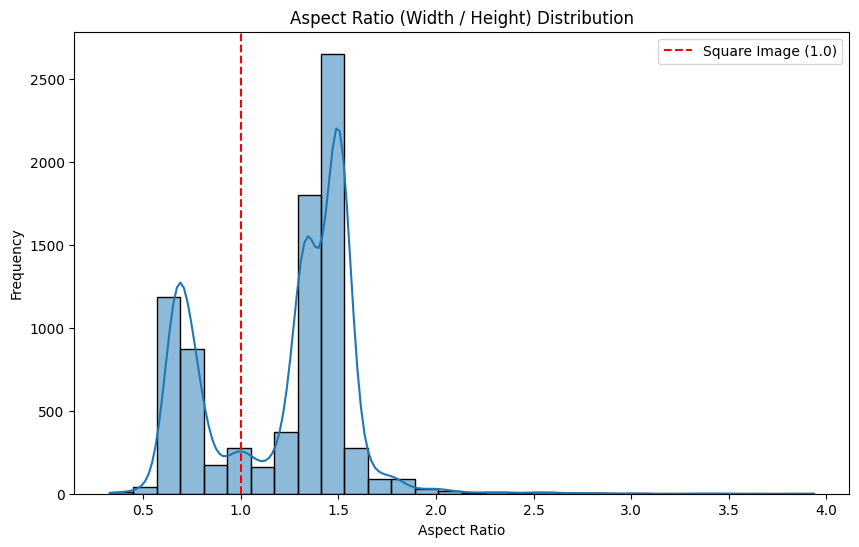

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(aspect_ratios, bins=30, kde=True, ax=ax)
ax.set_title("Aspect Ratio (Width / Height) Distribution")
ax.set_xlabel("Aspect Ratio")
ax.set_ylabel("Frequency")
ax.axvline(x=1.0, color='r', linestyle='--', label='Square Image (1.0)')

fig.savefig(os.path.join(output_dir, "eda_image_aspect_ratio_distribution.png")
plt.legend()
plt.show()

#### Interpretation

Observations:
* Primary peak around 1.33–1.5, typical of landscape orientation (e.g., 4:3 ratio).
* Second smaller peak near 0.66, typical of portrait orientation (e.g., 2:3 ratio).
* Very few square images (aspect ratio ≈ 1.0, marked by the red dashed line).
* A few outliers with high ratios (>2) — possibly wide panoramas — and low ratios (<0.5) — maybe tall portraits.

Summary:
* Most images are landscape (width > height).
* Some portrait images, but few square ones.
* Dataset has diverse aspect ratios, which could affect model training (e.g., CNNs assuming fixed input shape).

### Color Analysis

#### Color Distribution

In [8]:
r_hist, g_hist, b_hist = np.zeros(256), np.zeros(256), np.zeros(256)
n_images = 0

for filename in tqdm(os.listdir(image_folder), desc="Processing image colors..."):
    if filename.endswith((".jpg", ".jpeg", ".png")):
        with Image.open(os.path.join(image_folder, filename)) as img:
            img = img.convert("RGB")
            r, g, b = img.split()
            r_hist += np.array(r.histogram())
            g_hist += np.array(g.histogram())
            b_hist += np.array(b.histogram())
            n_images += 1

# Normalize
r_hist /= n_images
g_hist /= n_images
b_hist /= n_images

Processing image colors...: 100%|██████████████████████████████████████████████████| 8092/8092 [01:16<00:00, 105.75it/s]


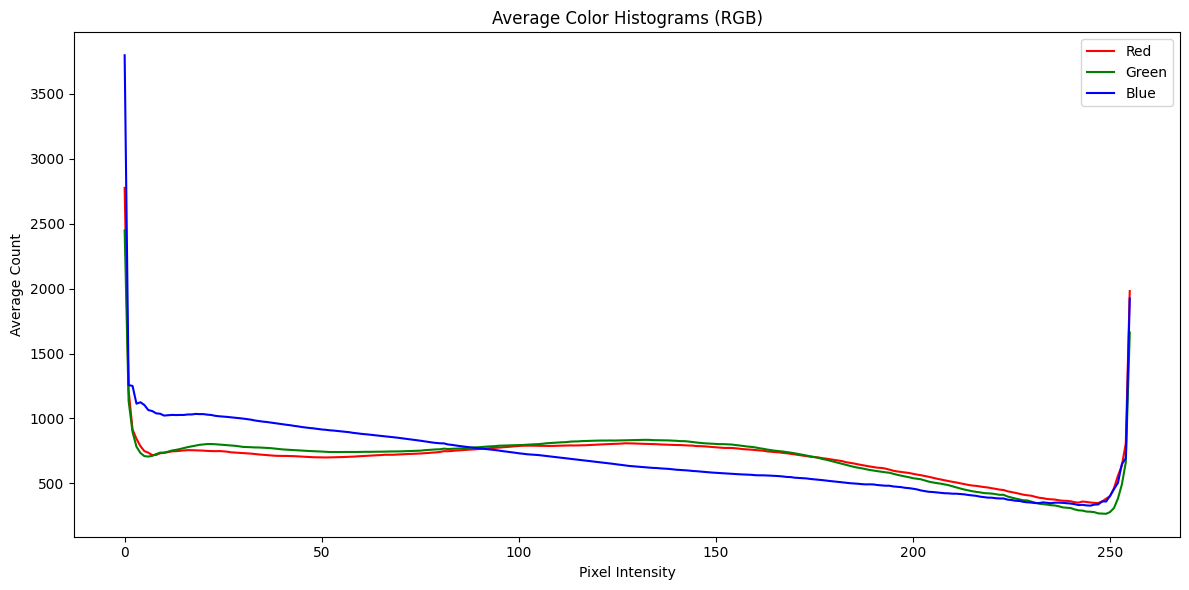

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(r_hist, color='red', label='Red')
ax.plot(g_hist, color='green', label='Green')
ax.plot(b_hist, color='blue', label='Blue')
ax.set_title("Average Color Histograms (RGB)")
ax.set_xlabel("Pixel Intensity")
ax.set_ylabel("Average Count")
ax.legend()
fig.savefig(os.path.join(output_dir, "eda_image_color_distribution.png")
plt.tight_layout()
plt.show()

#### Interpretation

Observations:
* Dark pixels dominate: All three channels spike near 0 intensity.
* There's also a noticeable spike at the very high end (255) — likely due to white backgrounds or bright lighting.
* Blue channel has consistently higher values across the range, especially in darker tones.

Summary:
* Dataset skews slightly toward darker images.
* Blue is the most dominant channel, especially at lower intensities. This might reflect outdoor scenes (e.g., sky, water).
* There’s a subtle green-red balance in mid-tones.

Implications:
* CNNs trained on this data might inherit a color/light bias (e.g., favoring cool tones).
* Normalization or data augmentation (brightness, contrast) might help balance this during training.

## Caption Analysis

### Caption File Path

In [4]:
captions_file = "../data/raw/flickr8k_captions.csv"

### Captions per Image

In [11]:
# Load CSV
df = pd.read_csv(captions_file)

# Count captions per image
caption_counts = df['image'].value_counts()

# Check basic stats
print("Unique images:", df['image'].nunique())
print("Total captions:", len(df))
print("Average captions per image:", caption_counts.mean())

# Identify any anomalies
print(f"\nList of Images with < 5 captions:\n\t{caption_counts[caption_counts < 5]}")
print(f"\nList of Images with > 5 captions:\n\t{caption_counts[caption_counts > 5]}")

Unique images: 8091
Total captions: 40455
Average captions per image: 5.0

List of Images with < 5 captions:
	Series([], Name: count, dtype: int64)

List of Images with > 5 captions:
	Series([], Name: count, dtype: int64)


#### Interpretation

All images have 5 captions as expected.

### Caption Length Distribution

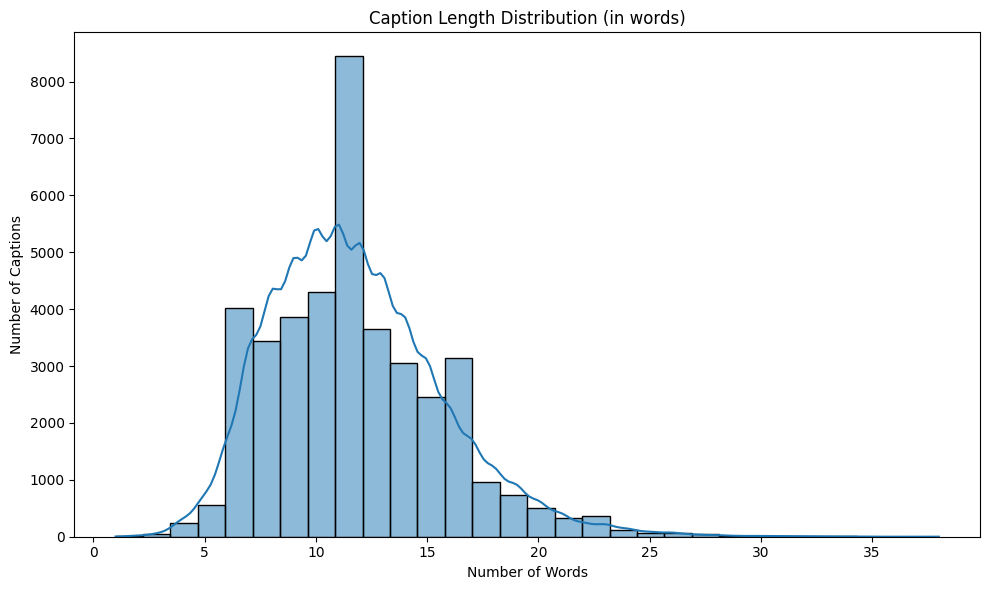

Summary Stats
Min length: 1
Max length: 38
Mean length: 11.78259794833766
Median length: 11.0


In [12]:
# Add a column for caption length (in words)
df['caption_len'] = df['caption'].apply(lambda x: len(str(x).split()))

fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(df['caption_len'], bins=30, kde=True)
ax.set_title("Caption Length Distribution (in words)")
ax.set_xlabel("Number of Words")
ax.set_ylabel("Number of Captions")
fig.savefig(os.path.join(output_dir, "eda_caption_length_distribution.png")
plt.tight_layout()
plt.show()

# Stats
print("Summary Stats")
print(f"Min length: {df['caption_len'].min()}")
print(f"Max length: {df['caption_len'].max()}")
print(f"Mean length: {df['caption_len'].mean()}")
print(f"Median length: {df['caption_len'].median()}")

#### Interpretation

* Most captions fall between 8–15 words, with a slightly right-skewed distribution.
* Captions are relatively short and consistent, ideal for NLP tasks like image captioning.
* The rare long captions (up to 38 words) are outliers and might need review for noise or verbosity.

### Vocab & Word Frequencies

Vocabulary size: 8918


/tmp/ipykernel_1089/3332804139.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45) #, ha='right')


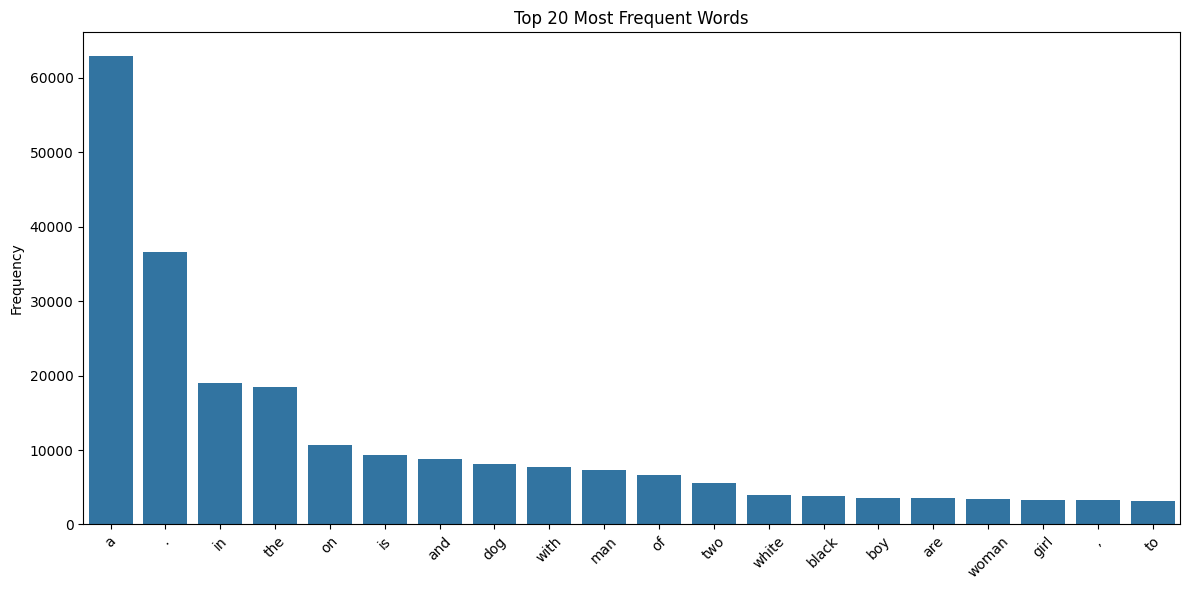

In [19]:
# Tokenize captions into words
all_words = []
for caption in df['caption']:
    all_words.extend(str(caption).lower().split())

# Count frequency
word_freq = Counter(all_words)

# Vocabulary size
vocab_size = len(word_freq)
print("Vocabulary size:", vocab_size)

# Top 20 frequent words
common_words = word_freq.most_common(20)

# Plot
words, freqs = zip(*common_words)
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=list(words), y=list(freqs), ax=ax)
ax.set_title("Top 20 Most Frequent Words")
ax.set_ylabel("Frequency")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45) #, ha='right')
fig.savefig(os.path.join(output_dir, "eda_most_frequent_words.png")
plt.tight_layout()
plt.show()

#### Interpretation

Observations
* Most frequent words include articles, prepositions, and nouns: "a", "in", "the", "on", "dog", "man", etc.
* Common objects: "dog", "man", "woman", "boy", "girl", "black", "white"

#### Rare Words Analysis

In [14]:
# Rare words threshold (e.g., words that occur once or twice)
rare_thresh = 1
rare_words = [word for word, count in word_freq.items() if count <= rare_thresh]

print("Rare words (≤ 1 occurrence):", len(rare_words))
print("Percentage of rare words in vocab:", len(rare_words) / vocab_size * 100)

Rare words (≤ 1 occurrence): 3681
Percentage of rare words in vocab: 41.276070867907606


#### Interpretation

Rare Words:
* 3681 words occur only once, making up ~41% of the vocabulary.
* High rare word ratio indicates a long tail distribution — typical in natural language.

Implication: Consider vocabulary pruning or subword tokenization to reduce sparsity.

### POS Tagging Distribution

### N-gram Analysis

/tmp/ipykernel_1089/3921844527.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45) #, ha='right')


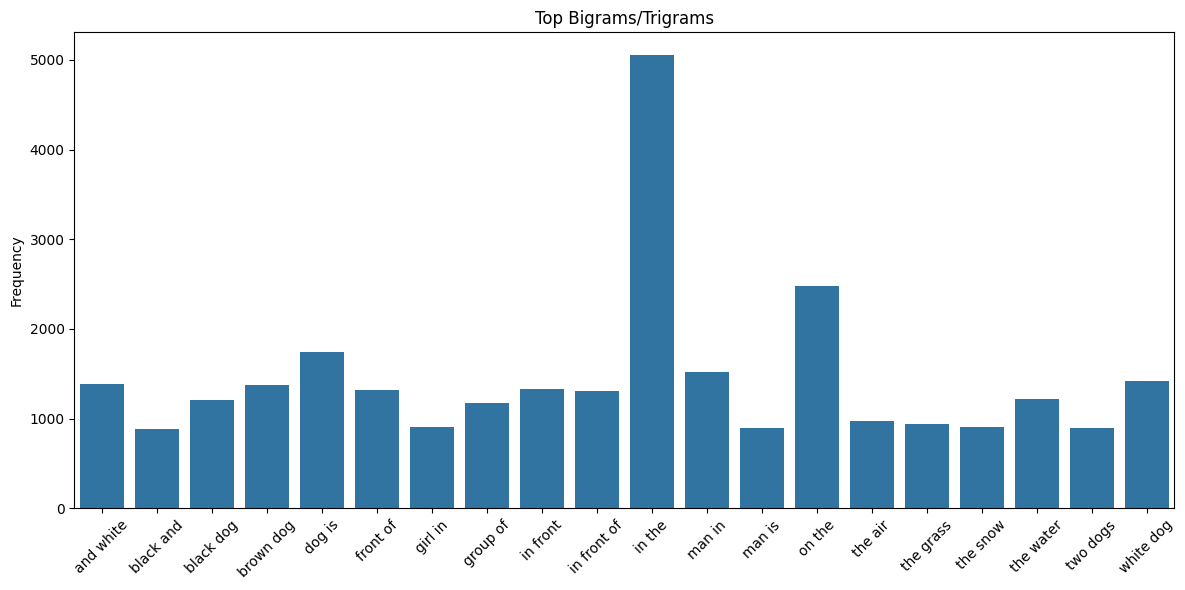

In [16]:
vectorizer = CountVectorizer(ngram_range=(2, 3), max_features=20)
X = vectorizer.fit_transform(df['caption'].astype(str))
ngrams = vectorizer.get_feature_names_out()
counts = X.sum(axis=0).A1

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=ngrams, y=counts, ax=ax)
ax.set_title("Top Bigrams/Trigrams")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45) #, ha='right')
ax.set_ylabel("Frequency")
fig.savefig(os.path.join(output_dir, "eda_top_ngrams.png")
plt.tight_layout()
plt.show()

#### Interpretation

Observations:
* Most common n-grams: "in the", "on the", "dog is", "group of", "black dog", etc.
* "in the" appears significantly more often than any other, which shows a strong syntactic pattern (likely from “A dog is in the…” etc.)

Implications:
* Captions follow grammatical sentence structures, dominated by common phrases — a positive sign for training language models.
* Frequent object mentions and prepositions suggest descriptive image captions (e.g., spatial relations: “on the grass”, “in front of”).

### Punctuation & Special Characters

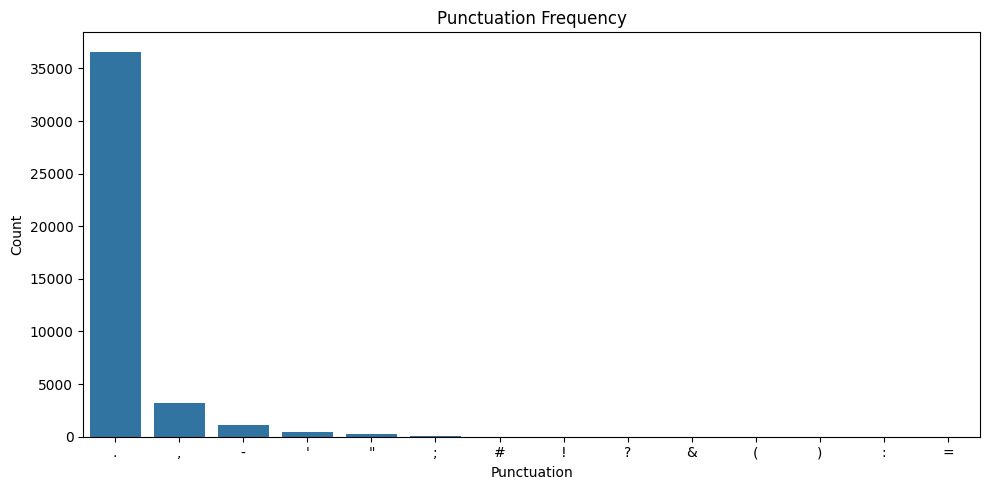

In [17]:
punct_count = Counter()
for caption in df['caption']:
    puncts = re.findall(f"[{re.escape(string.punctuation)}]", str(caption))
    punct_count.update(puncts)

# Plot
puncts, p_counts = zip(*punct_count.most_common())
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=list(puncts), y=list(p_counts))
ax.set_title("Punctuation Frequency")
ax.set_xlabel("Punctuation")
ax.set_ylabel("Count")
fig.savefig("../figures/eda_puncation_frequency.png")
plt.tight_layout()
plt.show()

#### Interpretation

Observations:
* . (period) is overwhelmingly the most used punctuation.
* Other marks (,, -, ', ") are much less common.
* Symbols like #, ;, ?, ! are almost absent.

Implication:
* Captions are typically simple declarative sentences, likely ending with a period.
* Very few complex punctuation marks or symbols — indicating clean, natural sentence structures.

### Case Sensitivity

In [18]:
# Count uppercase vs lowercase words
upper_words = sum(1 for word in all_words if word.isupper())
titlecase_words = sum(1 for word in all_words if word.istitle())

print("Uppercase words:", upper_words)
print("Titlecase words:", titlecase_words)
print("Lowercase words:", sum(1 for word in all_words if word.islower()))

Uppercase words: 0
Titlecase words: 0
Lowercase words: 436338


#### Interpretation

Observation: No titlecase or uppercase words; all are lowercase — a clean and consistent preprocessing step has already been applied.

## Summary

| **Aspect**               | **Observation**                               | **Implication**                                                          |
| ------------------------ | --------------------------------------------- | ------------------------------------------------------------------------ |
| **Images**               |                                               |                                                                          |
| Unique images            | 8,091                                         | Dataset size is moderate, suitable for training and evaluation           |
| Captions per image       | Exactly 5                                     | Uniform distribution; beneficial for model consistency and evaluation    |
| Images with < 5 captions | None                                          | Confirms data completeness                                               |
| Images with > 5 captions | None                                          | Confirms uniform captioning                                              |
|                          |                                               |                                                                          |
| **Captions**             |                                               |                                                                          |
| Total captions           | 40,455                                        | Matches image count × captions per image                                 |
| Avg. caption length      | 11.78 words                                   | Captions are concise, useful for training compact language models        |
| Min / Max caption length | 1 / 38 words                                  | Some outliers exist; consider trimming/extending as needed               |
| Median caption length    | 11 words                                      | Most captions are around this length — tightly distributed               |
| Most frequent words      | "a", "in", "the", "dog", "man"                | Frequent use of determiners, prepositions, and common nouns              |
| Common n-grams           | "in the", "on the", "dog is", "black dog"     | Indicates structured, spatially descriptive language                     |
| Punctuation use          | Mostly periods (`.`)                          | Simple declarative sentences dominate                                    |
| Rare words               | 3,681 words (41.28% of vocab) occur only once | High vocabulary sparsity; consider pruning or using subword tokenization |
| Text casing              | All lowercase                                 | Indicates preprocessing already handled casing normalization             |

## Caption Diversity Analysis

In [10]:
def compute_diversity_scores(captions_dict: Dict[str, List[str]], use_bertscore: bool=True) -> pd.DataFrame:
    """
    Compute BLEU-4, METEOR, and BERTScore similarity (and diversity) per image.

    Returns:
        pd.DataFrame: DataFrame with similarity and diversity scores.
    """
    results = []

    for img_id, captions in tqdm(captions_dict.items(), desc="Evaluating diversity"):
        if len(captions) < 2:
            continue

        pairs = list(combinations(captions, 2))  # All pairs: 10 if 5 captions

        bleu_scores = []
        meteor_scores = []
        bert_ref, bert_cand = [], []

        for cap1, cap2 in pairs:
            # BLEU expects tokenized input
            bleu_score = compute_bleu_scores(
                references=[[cap1.split()]], candidates=[cap2.split()]
            )["BLEU-4"]
            bleu_scores.append(bleu_score)

            # METEOR: cap1 as ref, cap2 as cand
            meteor_scores.append(
                compute_meteor_scores([[cap1]], [cap2])
            )

            # Prepare for BERTScore later
            if USE_BERTSCORE:
                bert_ref.append(cap1)
                bert_cand.append(cap2)

        avg_bleu = np.mean(bleu_scores)
        avg_meteor = np.mean(meteor_scores)
        avg_bertscore = None

        if use_bertscore:
            bs_scores = compute_bertscore(bert_ref, bert_cand)
            avg_bertscore = bs_scores["BERTScore_F1"]

        results.append({
            "image_id": img_id,
            "avg_bleu4": avg_bleu,
            "avg_meteor": avg_meteor,
            "avg_bertscore_f1": avg_bertscore,
            "diversity_bleu4": 1 - avg_bleu,
            "diversity_meteor": 1 - avg_meteor,
            "diversity_bertscore": 1 - avg_bertscore if avg_bertscore is not None else None,
        })

    return pd.DataFrame(results)

In [12]:
# Load all captions
captions_dict = build_raw_captions_dict_from_csv(captions_file)

# Sample 10% of the dataset
seed = 42
sample_fraction = 0.1
random.seed(seed)
image_ids = sorted(captions_dict.keys())
sample_size = int(len(image_ids) * sample_fraction)
sampled_ids = random.sample(image_ids, sample_size)
sampled_dict = {img_id: captions_dict[img_id] for img_id in sampled_ids}

print(f"Evaluating {len(sampled_dict)} images for caption diversity...")

# Evaluate
df = compute_diversity_scores(sampled_dict, use_bertscore)

# Show summary
print("\n--- Diversity Summary ---")
print(df[["diversity_bleu4", "diversity_meteor", "diversity_bertscore"]].describe())

# Optionally save
save_file = "./tmp/caption_diversity_results.csv"
save_dir = os.path.dirname(save_file)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

df.to_csv("../outputs/tmp/caption_diversity_results.csv", index=False)
print(f"\nSaved results to {save_file}")

Evaluating 809 images for caption diversity...


Evaluating diversity:   0%|                                                                     | 0/809 [00:00<?, ?it/s]/home/curtis/anaconda3/envs/northeastern/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating diversity:   0%|                                                           | 1/809 [00:05<1:16:33,  5.68s/it]/home/curtis/anaconda3/envs/northeastern/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated 


--- Diversity Summary ---
       diversity_bleu4  diversity_meteor  diversity_bertscore
count       809.000000        809.000000           809.000000
mean          0.928952          0.655832             0.085183
std           0.046934          0.113274             0.017395
min           0.636526          0.198961             0.025875
25%           0.911066          0.588102             0.073404
50%           0.942432          0.665678             0.085261
75%           0.960589          0.738052             0.095969
max           0.985167          0.914255             0.139274

Saved results to caption_diversity_results.csv


#### Histograms of Diversity Scores

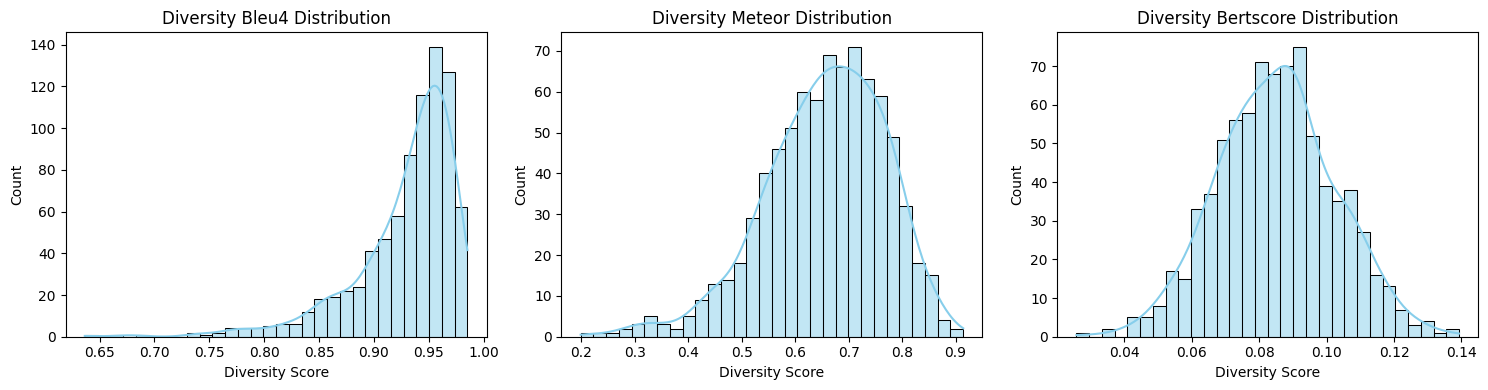

In [23]:
plt.figure(figsize=(15, 4))
for i, metric in enumerate(["diversity_bleu4", "diversity_meteor", "diversity_bertscore"]):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[metric], bins=30, kde=True, color="skyblue")
    plt.title(f"{metric.replace('_', ' ').title()} Distribution")
    plt.xlabel("Diversity Score")
    plt.ylabel("Count")
fig.savefig(os.path.join(output_dir, "eda_histograms_of_diversity_scores.png")
plt.tight_layout()
plt.show()

#### Pairwise Correlation Between Metrics

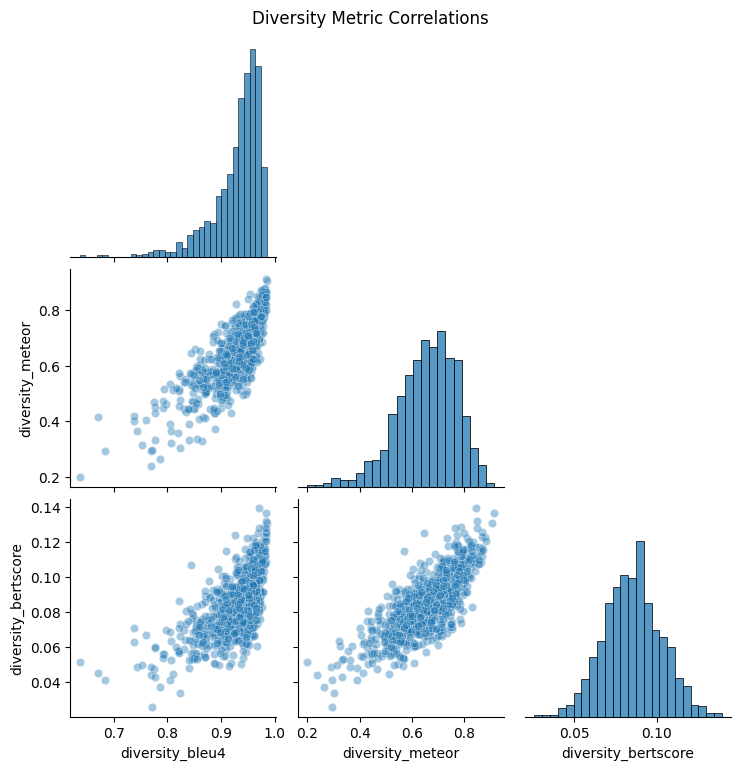

In [24]:
metrics = ["diversity_bleu4", "diversity_meteor", "diversity_bertscore"]

sns.pairplot(df[metrics], kind="scatter", corner=True, plot_kws={"alpha": 0.4})
plt.suptitle("Diversity Metric Correlations", y=1.02)
fig.savefig(os.path.join(output_dir, "eda_diversity_metric_correlations.png")
plt.show()

#### Highest and Lowest Diversity Images

In [15]:
# Most diverse images (top 5 by BERTScore)
n = 10
print("Most diverse image captions (by BERTScore):")
print(df.sort_values("diversity_bertscore", ascending=False).head(n)[["image_id", "diversity_bertscore"]])

Most diverse image captions (by BERTScore):
                      image_id  diversity_bertscore
263  3643684044_a131168127.jpg             0.139274
496  3127614086_9f1d3cf73d.jpg             0.136586
735  2338627102_6708a9b4fd.jpg             0.131838
443  3132760860_3e743a935d.jpg             0.130979
423   241346580_b3c035d65c.jpg             0.128858
802  3484841598_e26ee96aab.jpg             0.128316
450  3420278866_1d17c12713.jpg             0.127936
668  3695517194_2a6b604cb2.jpg             0.125923
391  2451114871_8617ae2f16.jpg             0.125497
730  2894217628_f1a4153dca.jpg             0.125456


In [16]:
# Least diverse images
print("\nLeast diverse image captions (by BERTScore):")
print(df.sort_values("diversity_bertscore", ascending=True).head(n)[["image_id", "diversity_bertscore"]])


Least diverse image captions (by BERTScore):
                      image_id  diversity_bertscore
747  2902486045_6298eb22ef.jpg             0.025875
525   538825260_a4a8784b75.jpg             0.033880
776  3326376344_3306bf439e.jpg             0.036985
517  1082379191_ec1e53f996.jpg             0.041213
170  3134644844_493eec6cdc.jpg             0.041289
677  3259002340_707ce96858.jpg             0.042771
611  2255266906_8222af18b9.jpg             0.043816
185  2861413434_f0e2a10179.jpg             0.044718
639  2417341107_97dbab9c5e.jpg             0.044904
201  3185662156_c877583c53.jpg             0.047316


#### Diversity Score Spread

/tmp/ipykernel_5929/999376822.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=melted, x="Metric", y="Diversity", palette="Set2")


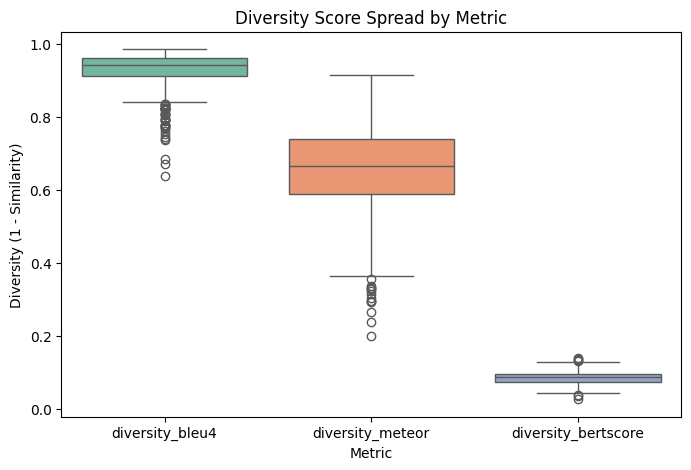

In [25]:
melted = df.melt(
    value_vars=["diversity_bleu4", "diversity_meteor", "diversity_bertscore"],
    var_name="Metric",
    value_name="Diversity"
)

plt.figure(figsize=(8, 5))
sns.boxplot(data=melted, x="Metric", y="Diversity", palette="Set2")
plt.title("Diversity Score Spread by Metric")
plt.ylabel("Diversity (1 - Similarity)")
# plt.grid(True)
fig.savefig(os.path.join(output_dir, "eda_diversity_score_spread_boxplots.png")
plt.show()

#### BLEU-4 Diversity (1 - BLEU-4 similarity)

Stats:
* Mean: ~0.929 (i.e., high diversity)
* Range: 0.636 → 0.985
* Distribution: Sharp peak near 0.95 (see hist and boxplot)

Interpretation:
* Captions for the same image tend to differ significantly in n-gram usage (esp. 4-grams).
* High BLEU-4 diversity usually indicates wording variety (different sentence constructions or vocab), even if semantics are similar.
* Outliers near 0.65 may suggest a few images with repetitive phrasing across captions.

#### METEOR Diversity

Stats:
* Mean: ~0.656 (moderate)
* Range: 0.199 → 0.914
* Distribution: Centered around 0.65, more evenly spread (see histogram)

Interpretation:
* Captions show moderate diversity in terms of word choice, synonyms, and paraphrases.
* Unlike BLEU, METEOR captures semantic overlap, so the slightly lower scores imply some captions say the same thing using different words.
* There's more spread — suggesting METEOR is better at catching images where captions are both highly varied or nearly redundant.

#### BERTScore Diversity (1 - BERTScore F1)

Stats:
* Mean: ~0.085 (i.e., high semantic similarity)
* Range: 0.026 → 0.139
* Distribution: Narrow and symmetric

Interpretation:
* Despite different surface forms (as BLEU/METEOR suggested), the underlying semantics of the captions are highly aligned.
* Captions mostly describe the same core content — consistent, but perhaps lacking creativity/divergence.
* The narrow spread implies stable semantic interpretation, which is good for factual datasets like MS-COCO.

#### Cross-Metric Insights

From the correlation plot, it's clear that:
* All three metrics are positively correlated (captions that are diverse by BLEU tend to be diverse by METEOR and BERTScore too).
* METEOR and BERTScore have a tighter relationship than BLEU and BERTScore — not surprising, as both account for semantic overlap rather than just phrasing.

### Summary

* High semantic redundancy (no captions are exactly the same).
* The dataset appears to offer diverse language while maintaining semantic alignment, which is ideal for training captioning models that need both creativity and precision.

| Insight                        | Explanation                                                                             |
| ------------------------------ | --------------------------------------------------------------------------------------- |
| **High BLEU-4 diversity**      | Suggests a healthy range of surface-level phrasing — good linguistic variety.           |
| **Moderate METEOR diversity**  | Captions differ in wording and some semantics, but there's a shared descriptive base.   |
| **Low BERTScore diversity**    | Despite variety in phrasing, captions convey similar meanings — consistent annotations. |
